<a href="https://colab.research.google.com/github/DONG-WEI-YANG/113_DLBOI_Homework3/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims
import os

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode
from matplotlib.axes import Axes



c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda')
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

Using 0 GPUs
CUDA is available: False


In [4]:
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        # Calculating Loss
        epoch_loss.append(loss.item())

        # Calculating Metrics
        predicts = (preds > 0.5).float()
        predicts = predicts.view(-1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, total_time, best_acc

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc

# Data Preparation

In [5]:
import os


In [6]:
# define folder path for each set
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
val_path = 'chest_xray/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_path ='chest_xray\\train'


# Model

In [7]:
import torch
import torch.nn as nn

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 256 * 1, 256),  # Increased from 128 to 256
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(256, 128),  # Changed to 128
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1),
    nn.Sigmoid()
)

# Move the model to the appropriate device
model.to(device)

# Print the model
print(model)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=256, bias=True)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=256, out_features=128, bias=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=64, out_features=1, bias=True)
  (14): Sigmoid()
)


# Loop

In [14]:
# hyperparameter  

lr = 0.0001
weight_decay = 0.00003
epochs =10
optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
criterion = nn.BCELoss()

# save checkpoint
save = 'model'

In [15]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0
output_list = []

for epoch in range(epochs):
    train_loss, train_acc, train_time = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)
    lr_scheduler.step(val_acc)

Epoch 1/10 - loss: 0.0319 - train_acc: 99.02% - val_loss: 0.3986 - val_acc: 75.00% - time: 65.38s
Epoch 2/10 - loss: 0.0274 - train_acc: 99.22% - val_loss: 0.0845 - val_acc: 100.00% - time: 67.94s
Epoch 3/10 - loss: 0.0222 - train_acc: 99.46% - val_loss: 0.0927 - val_acc: 93.75% - time: 75.27s
Epoch 4/10 - loss: 0.0295 - train_acc: 99.27% - val_loss: 0.0486 - val_acc: 100.00% - time: 68.90s
Epoch 5/10 - loss: 0.0272 - train_acc: 99.41% - val_loss: 0.1659 - val_acc: 93.75% - time: 90.22s
Epoch 6/10 - loss: 0.0305 - train_acc: 99.07% - val_loss: 0.1550 - val_acc: 93.75% - time: 67.28s
Epoch 7/10 - loss: 0.0260 - train_acc: 99.32% - val_loss: 0.4046 - val_acc: 75.00% - time: 63.06s
Epoch 8/10 - loss: 0.0151 - train_acc: 99.85% - val_loss: 0.0549 - val_acc: 100.00% - time: 63.16s
Epoch 9/10 - loss: 0.0158 - train_acc: 99.61% - val_loss: 0.1515 - val_acc: 93.75% - time: 64.28s
Epoch 10/10 - loss: 0.0137 - train_acc: 99.76% - val_loss: 0.0655 - val_acc: 100.00% - time: 61.37s


# Graph

<Figure size 1200x500 with 0 Axes>

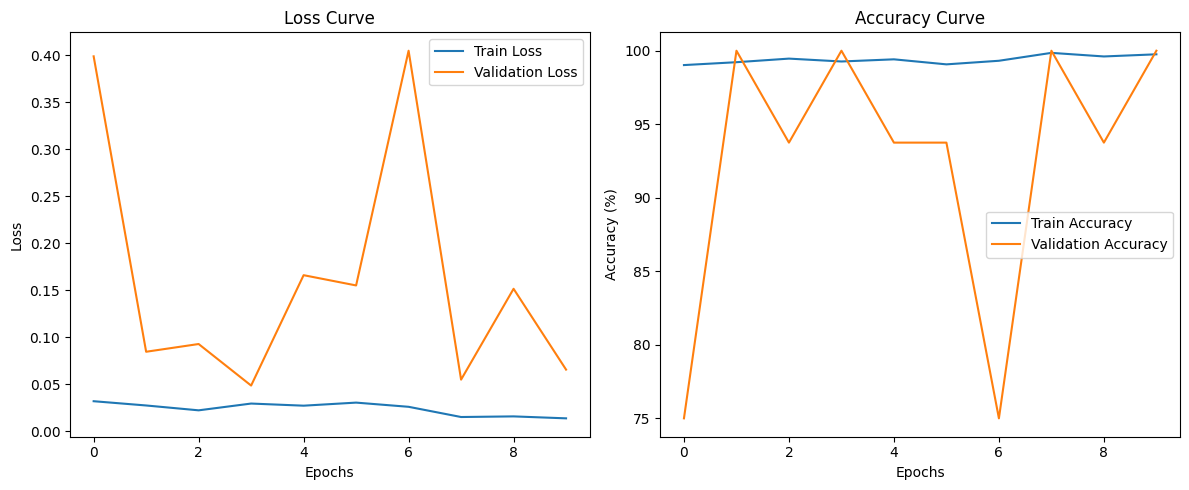

In [16]:
import matplotlib.pyplot as plt

# Create the figure and subplots
plt.figure(figsize=(12, 5))

# Placeholder data (replace these with your actual data)
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        model.fit(X_train, y_train, epochs=1, verbose=0)
        train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy * 100)    # %
    return epochs, train_losses, val_losses, train_accuracies, val_accuracies

# Create the figure and subplots
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()

# Evaluate

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define your model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Adjust input size for flattened images (e.g., 28x28 for MNIST)
        self.fc2 = nn.Linear(128, 10)        # Output layer for 10 classes (e.g., MNIST)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # Output shape: (batch_size, num_classes)

# Evaluation function
def evaluate(model, device, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Outputs shape: (batch_size, num_classes)
            loss = criterion(outputs, labels)  # Labels shape: (batch_size,)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Main code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = MyModel().to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Load model weights (if available)
model_path = 'model.pth'
try:
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
except Exception as e:
    print(f"Failed to load model weights: {e}")

# Define transformations for the test dataset
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Adjust size if needed
    transforms.ToTensor(),
])

# Load your test dataset (e.g., MNIST)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create test DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Perform evaluation
avg_test_loss, avg_test_acc = evaluate(model, device, test_loader, criterion)
print(f'Average Test Loss: {avg_test_loss}, Average Test Accuracy: {avg_test_acc}%')


Average Test Loss: 2.3077556538505677, Average Test Accuracy: 10.7%


# Tune hyperparameter

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your model (replace with your model definition)
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 256 * 1, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize the model
model = YourModel().to(device)

# Define hyperparameters
weight_decays = [3e-5,1e-5,3e-4 ,1e-4, 3e-3,1e-3]  # Common weight decay values
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]  # Common learning rates
epochs_list = list(range(5, 30, 5))  # From 5 to 30 with step of 5
batch_size = 64  # Suggested batch size

# Create DataLoader with num_workers for parallel data loading
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define loss function
criterion = nn.BCELoss()  # For binary classification

# Function to train the model
def train_model(model, criterion, data_loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to device

        # Adjust the shape and type of labels
        labels = labels.unsqueeze(1).float()  # Change shape from [64] to [64, 1] and convert to Float

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        total_loss += loss.item()  # Accumulate loss

    avg_loss = total_loss / len(data_loader)  # Calculate average loss
    return avg_loss

# Function to validate the model
def validate_model(model, criterion, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():  # Disable gradient tracking
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device

            # Adjust the shape and type of labels
            labels = labels.unsqueeze(1).float()  # Change shape from [64] to [64, 1] and convert to Float

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            total_loss += loss.item()  # Accumulate loss

            # Calculate accuracy
            predicted = (outputs > 0.5).float()  # Assuming binary classification
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)  # Average loss
    accuracy = 100 * correct_predictions / len(data_loader.dataset)  # Accuracy
    return avg_loss, accuracy

# Initialize a list to store results
results = []

# Hyperparameter tuning loop
for lr in learning_rates:
    for wd in weight_decays:
        for epochs in epochs_list:
            # Initialize optimizer and learning rate scheduler
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')

            # Train the model
            for epoch in range(epochs):
                avg_train_loss = train_model(model, criterion, train_loader, optimizer)
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}')

                # Validate the model
                avg_val_loss, val_accuracy = validate_model(model, criterion, val_loader)
                print(f'Epoch {epoch+1}/{epochs}, Val Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

            # Store the results
            results.append({
                'learning_rate': lr,
                'weight_decay': wd,
                'epochs': epochs,
                'val_loss': avg_val_loss,
                'val_accuracy': val_accuracy
            })

            # Adjust learning rate based on validation performance
            lr_scheduler.step(avg_val_loss)

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Find the best combination based on validation accuracy
best_result = results_df.loc[results_df['val_accuracy'].idxmax()]

# Print the best combination
print("\nBest Hyperparameter Combination:")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Weight Decay: {best_result['weight_decay']}")
print(f"Epochs: {best_result['epochs']}")
print(f"Validation Loss: {best_result['val_loss']:.4f}")
print(f"Validation Accuracy: {best_result['val_accuracy']:.2f}%")

# Now use the best parameters to reinitialize and train the model
best_lr = best_result['learning_rate']
best_wd = best_result['weight_decay']
best_epochs = best_result['epochs']

# Reinitialize the model, optimizer, and scheduler with the best hyperparameters
model = YourModel().to(device)  # Replace with your model definition
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')

# Train the model again using the best parameters
for epoch in range(best_epochs):
    avg_train_loss = train_model(model, criterion, train_loader, optimizer)
    print(f'Epoch {epoch+1}/{best_epochs}, Train Loss: {avg_train_loss:.4f}')

    # Validate the model
    avg_val_loss, val_accuracy = validate_model(model, criterion, val_loader)
    print(f'Epoch {epoch+1}/{best_epochs}, Val Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Adjust learning rate based on validation performance
    lr_scheduler.step(avg_val_loss)

# Save the best model
torch.save(model.state_dict(), 'best_model.pth')


Epoch 1/5, Train Loss: 0.5575
Epoch 1/5, Val Loss: 0.6375, Validation Accuracy: 62.50%
Epoch 2/5, Train Loss: 0.4808
Epoch 2/5, Val Loss: 0.6122, Validation Accuracy: 50.00%
Epoch 3/5, Train Loss: 0.4602
Epoch 3/5, Val Loss: 0.5958, Validation Accuracy: 68.75%
Epoch 4/5, Train Loss: 0.4545
Epoch 4/5, Val Loss: 0.5880, Validation Accuracy: 62.50%
Epoch 5/5, Train Loss: 0.4369
Epoch 5/5, Val Loss: 0.5408, Validation Accuracy: 93.75%
Epoch 1/10, Train Loss: 0.4296
Epoch 1/10, Val Loss: 0.5154, Validation Accuracy: 81.25%
Epoch 2/10, Train Loss: 0.4282
Epoch 2/10, Val Loss: 0.6109, Validation Accuracy: 56.25%
Epoch 3/10, Train Loss: 0.4174
Epoch 3/10, Val Loss: 0.5218, Validation Accuracy: 93.75%
Epoch 4/10, Train Loss: 0.4150
Epoch 4/10, Val Loss: 0.4921, Validation Accuracy: 93.75%
Epoch 5/10, Train Loss: 0.3928
Epoch 5/10, Val Loss: 0.5404, Validation Accuracy: 75.00%
Epoch 6/10, Train Loss: 0.4056
Epoch 6/10, Val Loss: 0.5212, Validation Accuracy: 81.25%
Epoch 7/10, Train Loss: 0.3932
